In [1]:
%pip install torch torchvision torchaudio tqdm transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
!pip install scikit-image scikit-learn torchsummary

In [5]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week01-pytorch_intro/notmnist.py
    !touch .setup_complete

# Task 1. Tensors (1 point)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

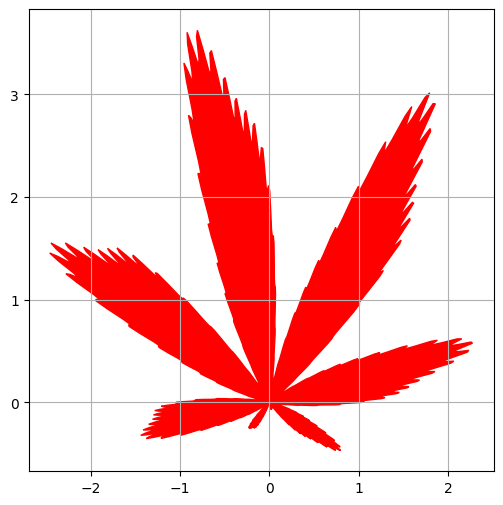

In [6]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.sin(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6, 6])
plt.fill(x, y, color='r')
plt.grid()

# Task 2: Going deeper (6 points)

Your ultimate task here is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that __reaches at least 80% accuracy__ and has __at least 2 linear layers__ in it.

With 10 classes you need __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)) loss. You can write it any way you want, but we recommend to use log_softmax function from pytorch, since it is more numerically stable.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you nice score.

__Win conditions:__
* __Your model must be nonlinear,__ but not necessarily deep.
* __Train your model with your own SGD__ - which you will have to implement
* __For this task only, please do not use the contents of `torch.nn` and `torch.optim`.__ That's for the next task.
* __Do not use Conv layers__

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st. 2nd, 3rd places).

In [7]:
from notmnist import load_notmnist
X_train, y_train, X_val, y_val = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_val = X_train.reshape([-1, 784]), X_val.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


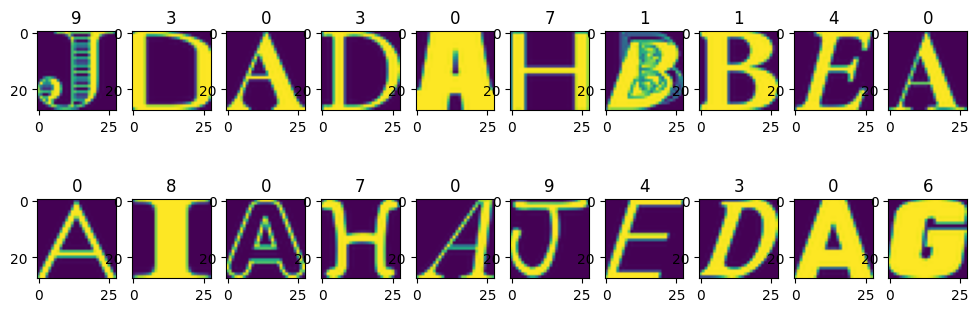

In [8]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14043, 784), (14043,), (4681, 784), (4681,))

In [10]:
classes = np.unique(y_train)
n_classes = len(classes)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
class CustomNet:
    def __init__(self, hidden_size, in_size=28*28, num_classes=n_classes):
        self.W1 = torch.randn(in_size, hidden_size, device=DEVICE, requires_grad=True)
        self.b1 = torch.zeros(hidden_size, device=DEVICE, requires_grad=True)
        self.W2 = torch.randn(hidden_size, hidden_size, device=DEVICE, requires_grad=True)
        self.b2 = torch.zeros(hidden_size, device=DEVICE, requires_grad=True)
        self.W3 = torch.randn(hidden_size, num_classes, device=DEVICE, requires_grad=True)
        self.b3 = torch.zeros(num_classes, device=DEVICE, requires_grad=True)

        self.params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        pass
    def forward(self, x) -> torch.Tensor:
        x = torch.as_tensor(x, device=DEVICE)
        x = x @ self.W1 + self.b1
        # x = torch.relu(x)
        x = x @ self.W2 + self.b2
        x = torch.relu(x)
        x = x @ self.W3 + self.b3

        return x
    def parameters(self) -> list[torch.Tensor]:
        return self.params

In [12]:
net = CustomNet(28)
out = net.forward(torch.randn(2, 28*28, device=DEVICE))
assert len(out.shape) == 2
assert out.shape[-1] == n_classes

In [13]:
import torch.nn.functional as F

def cross_entropy_loss(logits, target):
    N = logits.size(0)
    # Get the log probabilities
    log_probs =F.log_softmax(logits, dim=1)
    # Gather the log probabilities at the target indices
    log_probs_at_target = log_probs[torch.arange(N), target]
    # Compute the negative log likelihood
    nll = -log_probs_at_target.sum()
    return nll / N

y_tmp = torch.tensor(y_train[:2], device=DEVICE)
cross_entropy_loss(out, y_tmp), torch.nn.CrossEntropyLoss()(out, y_tmp)

(tensor(733.7488, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(733.7488, device='cuda:0', grad_fn=<NllLossBackward0>))

In [14]:
class CustomSGD:
    def __init__(self, model, lr=1e-4):
        self.model = model
        self.lr = lr

    def step(self) -> None:
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param -= self.lr * param.grad

    def zero_grad(self) -> None:
        for param in self.model.parameters():
            param.grad = None

In [15]:
def iterate_minibatches(X, y, batch_size):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield torch.from_numpy(X[ix]), torch.from_numpy(y[ix])

In [16]:
def train(net, optimizer, loss_fn, n_epoch=20):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        # Training
        # net.train(True)
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size=64):
            x_batch =torch.as_tensor(x_batch).to(DEVICE).float()
            y_batch = torch.as_tensor(y_batch).to(DEVICE)


            probs = net.forward(x_batch)
            # Forward
            loss = loss_fn(probs, y_batch)
            loss_batches.append(loss.detach().cpu().numpy())

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accuracy
            acc_batches += (probs.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        # net.eval()
        with torch.no_grad():
            acc_batches=[]
            loss_batches=[]
            for x_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size=64):
                x_batch = torch.as_tensor(x_batch).to(DEVICE).float()
                y_batch = torch.as_tensor(y_batch).to(DEVICE)
                probs = net.forward(x_batch)

                # Forward
                loss = loss_fn(probs, y_batch)
                loss_batches.append(loss.detach().cpu().numpy())
                # Accuracy
                acc_batches += (probs.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()

            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("Acc")
        ax2.plot(acc_history, 'b', label='train acc')
        ax2.plot(val_acc_history, 'r', label='val acc')
        plt.axhline(y = 0.8, color = 'g', linestyle = '--')

        plt.legend()
        plt.show()
    return max(val_acc_history)

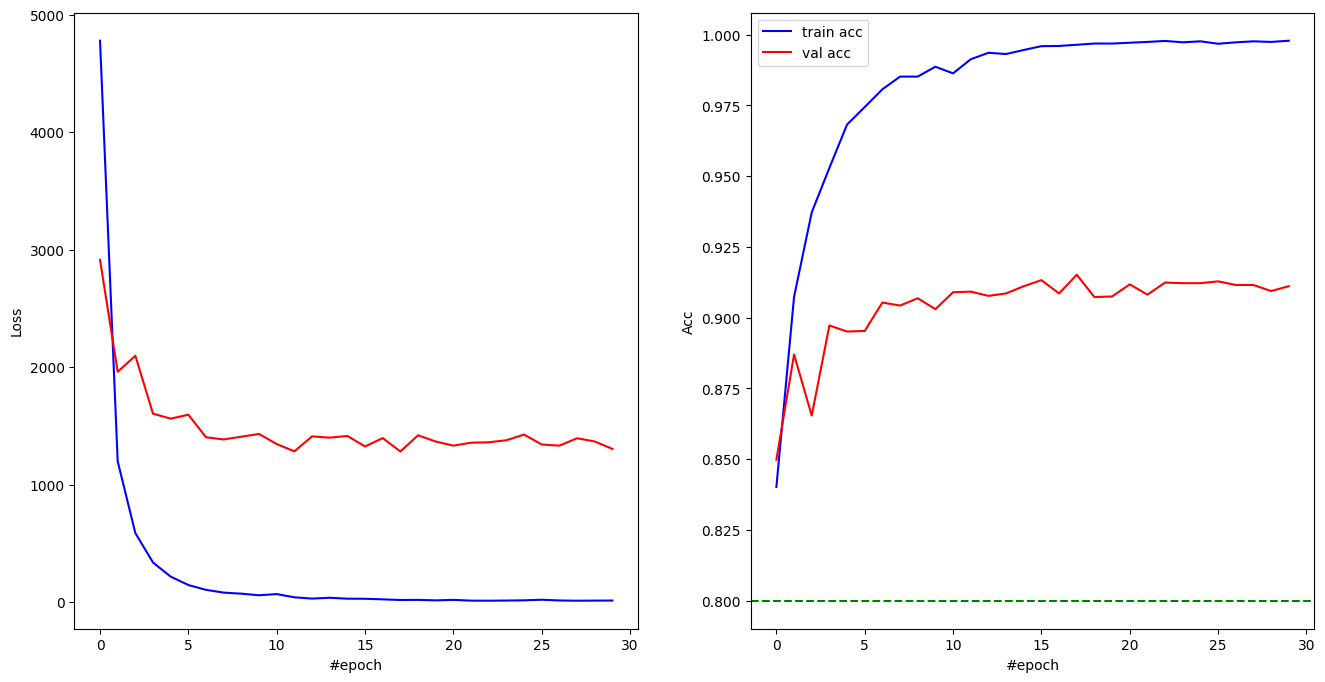

np.float64(0.9151890621662038)

In [ ]:
net = CustomNet(1024)
opt = CustomSGD(net, lr=0.003)
train(net, opt, cross_entropy_loss, 30)

### Hints:
  - You'll have to use matrix W(feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `torch.softmax`
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a ReLU nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid  
  - If anything seems wrong, try going through one step of training and printing everything you compute.
  - If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `torch.log_softmax(last_linear_layer_outputs)`.

# Task 3. Overfitting (4 points)


Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
0. Fill the gaps in training loop and architectures.
1. Train a tiny __FC__ network.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Train a network that achieves $\geq 0.885$ test accuracy. Again you should use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

__Please, write a small report describing your ideas, tries and achieved results in the end of this task.__

*Note*: in task 3 your goal is to make the network from task 2 less prone to overfitting. And then to train the network that achives $\geq 0.885$ test accuracy, so it can be different.

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st, 2nd, 3rd places).

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [18]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [19]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]


In [20]:
fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, train_size=50000)

In [21]:
len(fmnist_dataset_train), len(fmnist_dataset_val), len(fmnist_dataset_test)

(50000, 10000, 10000)

In [22]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

torch.Size([128, 1, 28, 28])
torch.Size([128])


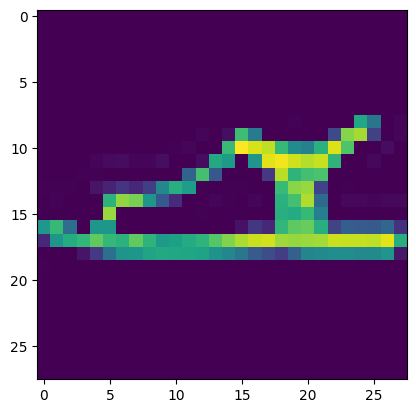

In [23]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    break

plt.imshow(img[0, 0]);

In [24]:
def train_val_loop(net, train_loader, val_loader, name, optimizer, criterion, n_epoch=20):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        net.train()
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in train_loader:
            x_batch = torch.as_tensor(x_batch).to(DEVICE).float()
            y_batch = torch.as_tensor(y_batch).to(DEVICE)


            # Forward
            pred = net.forward(x_batch)
            loss = criterion(pred, y_batch)
            loss_batches.append(loss.detach().cpu().numpy())

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accuracy
            acc_batches += (pred.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()


        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        net.eval()
        with torch.no_grad():
            acc_batches=[]
            loss_batches=[]
            for x_batch, y_batch in val_loader:
                x_batch = torch.as_tensor(x_batch).to(DEVICE).float()
                y_batch = torch.as_tensor(y_batch).to(DEVICE)

                # Forward
                pred = net.forward(x_batch)
                loss = criterion(pred, y_batch)
                loss_batches.append(loss.detach().cpu().numpy())

                # Accuracy
                acc_batches += (pred.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()


            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))

        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating loss {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Loss")
        plt.plot(loss_history, 'b', label='train')
        plt.plot(val_loss_history, 'r', label='validation')
        plt.legend()

        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating accuracy {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Accuracy")
        plt.plot(acc_history, 'b', label='train')
        plt.plot(val_acc_history, 'r', label='validation')
        plt.legend()

        plt.show()

def test_accuracy(model):
    model.eval()
    test_acc_batches = []
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test = X_test.to(DEVICE)
            Y_test = Y_test.to(DEVICE)
            out = model.forward(X_test)
            test_acc_batches += (out.argmax(axis=1) == Y_test).detach().cpu().numpy().tolist()
    print(f'Test accuracy {np.mean(test_acc_batches)}')

## Task 3.1 Tiny net
Train a tiny network just to validate correctness of train loop, net architecture, params.

In [25]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape * input_channels, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [26]:
model = TinyNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [27]:
torchsummary.summary(TinyNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


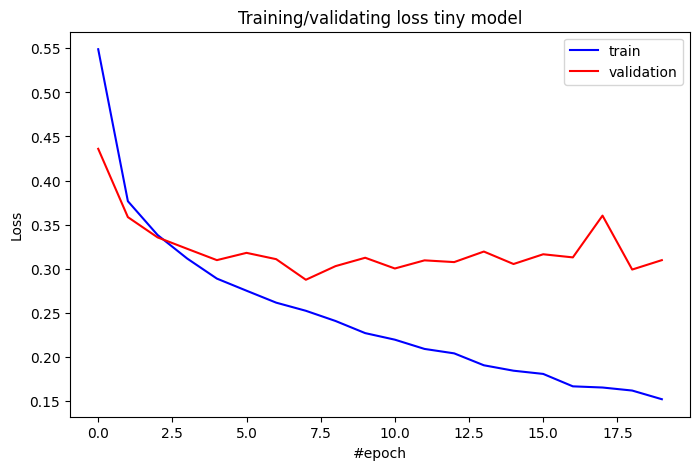

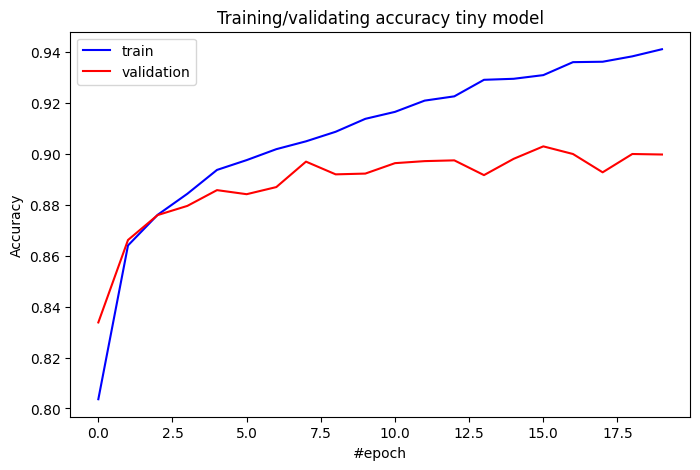

In [28]:
tiny_model = TinyNeuralNetwork().to(DEVICE)
opt = torch.optim.Adam(tiny_model.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()
n_epoch = 20


train_val_loop(tiny_model, train_loader=train_loader, val_loader=val_loader, name='tiny model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [29]:
test_accuracy(tiny_model)

Test accuracy 0.8921


Ну здесь вроде вполне адекватная модель с парочкой линейных слоев и регуляризацией
Дальше построим модель, которая должна будет переобучиться

## Task 3.2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [266]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=4096):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape * input_channels, hidden_size),
            nn.ReLU(),

            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),

            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),

            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [267]:
model = OverfittingNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [268]:
torchsummary.summary(OverfittingNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
         LeakyReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
              ReLU-7                 [-1, 4096]               0
            Linear-8                   [-1, 10]          40,970
Total params: 36,818,954
Trainable params: 36,818,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 140.45
Estimated Total Size (MB): 140.65
----------------------------------------------------------------


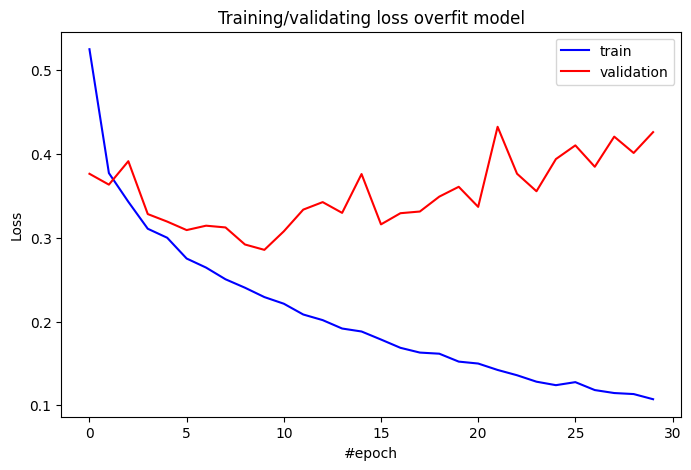

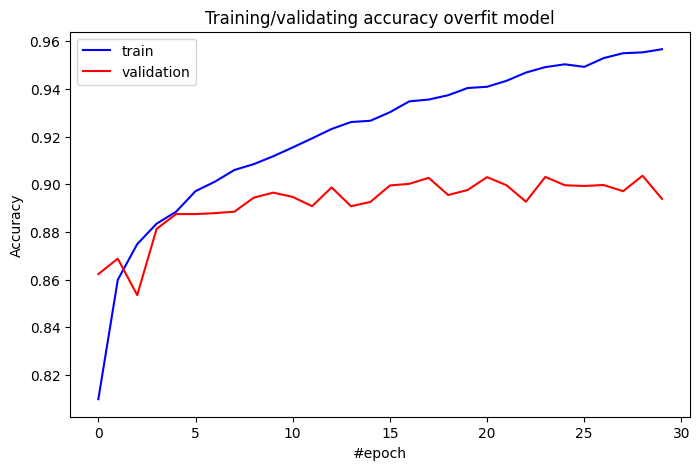

In [269]:
overfit_model = OverfittingNeuralNetwork().to(DEVICE)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epoch = 30


train_val_loop(overfit_model, train_loader=train_loader, val_loader=val_loader, name='overfit model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [270]:
test_accuracy(overfit_model)


Test accuracy 0.8822


Видим, что модель переобучилась, поскольку лосс на валидации начал деградировать, а ошибка на трейне довольно близка к 0, при этом улучшения в validating accuracy совершенно нет.

## Task 3.3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [287]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size = 512):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape * input_channels, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size),
            nn.AdaptiveMaxPool1d(128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, num_classes)

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [288]:
model = FixedNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [289]:
torchsummary.summary(FixedNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 512]         262,656
       BatchNorm1d-7                  [-1, 512]           1,024
         LeakyReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 512]         262,656
AdaptiveMaxPool1d-11                  [-1, 128]               0
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

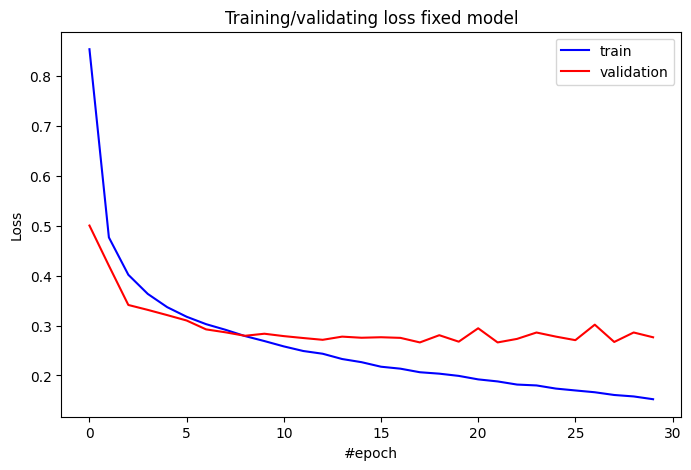

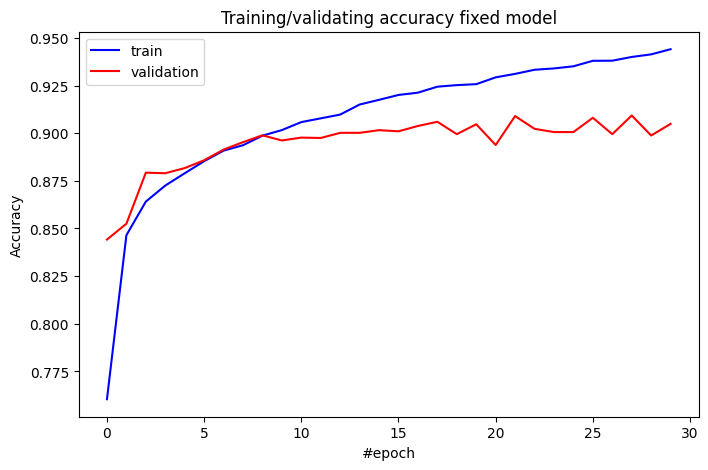

In [304]:
fixed_model = FixedNeuralNetwork().to(DEVICE)
opt = torch.optim.Adam(fixed_model.parameters(), lr=1e-4, weight_decay=1e-4, )
loss_func = nn.CrossEntropyLoss()
n_epoch = 30

# Your experiments, come here
train_val_loop(fixed_model, train_loader=train_loader, val_loader=val_loader, name='fixed model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [305]:
test_accuracy(fixed_model)

Test accuracy 0.894


### Conclusions:
_Write down small report with your conclusions and your ideas._

---

## 3.1
Здесь решил просто написать какую-то приемлемую, маленькую сеть. С accuracy похожим на кастомной сети.

---
## 3.2
Решил воспользоваться *золотым правилом* - настакать по больше слоев, ну не прям много. Словом, достаточно, чтобы сеть переобучилась.

---
## 3.3
Идея была в том, чтобы взять слои из 3.2 и добавить к ним различных слоев регуляризации, а именно: Dropout(), BatchNorm1d(), Max- и Avgpool(). И посмотреть упадет ли ошибка на валидации и что будет с accuracy. Дальше сидим, комбинируем по различному слои, подглядывая в архитектуры из лекции 3. Также решил, через оптимизатор добавить небольшую регуляризацию весов.

# Task 4. Your own nn layer. (4 points)

In [275]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

### Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer.
You should implement it.

- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [276]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        #it is important that we should multiply X @ W^T
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW =  gradOutput.T @ input
        self.gradb = gradOutput.sum(axis=0)


    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [277]:
def test_Linear():
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, n_in, n_out = 2, 3, 4
    for _ in range(100):
        # layers initialization
        torch_layer = torch.nn.Linear(n_in, n_out)
        custom_layer = Linear(n_in, n_out)
        custom_layer.W = torch_layer.weight.data.numpy()
        custom_layer.b = torch_layer.bias.data.numpy()

        layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
        next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

        # 1. check layer output
        custom_layer_output = custom_layer.updateOutput(layer_input)
        layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
        torch_layer_output_var = torch_layer(layer_input_var)
        assert np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6)

        # 2. check layer input grad
        custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
        torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
        torch_layer_grad_var = layer_input_var.grad
        assert np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6)

        # 3. check layer parameters grad
        custom_layer.accGradParameters(layer_input, next_layer_grad)
        weight_grad = custom_layer.gradW
        bias_grad = custom_layer.gradb
        torch_weight_grad = torch_layer.weight.grad.data.numpy()
        torch_bias_grad = torch_layer.bias.grad.data.numpy()
        assert np.allclose(torch_weight_grad, weight_grad, atol=1e-6)
        assert np.allclose(torch_bias_grad, bias_grad, atol=1e-6)

In [278]:
%%time
test_Linear()

CPU times: user 57.5 ms, sys: 3.05 ms, total: 60.6 ms
Wall time: 72.6 ms
